In [1]:
import sys, os
import scipy.sparse as sps
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sys.path.append(os.path.abspath('../kernel_inference'))
from new_york_inference import load

%matplotlib inline

In [2]:
kernel = load('../kernel_inference/filtered_paths2.txt')

In [3]:
def get_matrix(kernel, dt):
    keys = set(kernel.keys())
    for ends in kernel.values():
        keys.update(ends.keys())
    keys = sorted(keys)

    mat = []
    for start in keys:
        row = []
        for end in keys:
            row.append(sum(1 for t in kernel[start][end] if t < dt))
        total = float(sum(row))
        mat.append([r / total for r in row] if total > 0 else [0] * len(keys))            
    return np.array(mat, np.float64)

slice = get_matrix(kernel, 360)
        

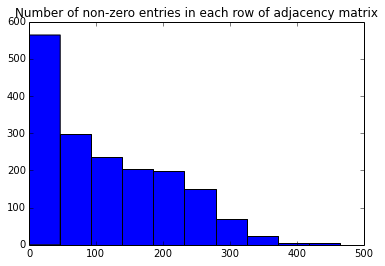

In [5]:
plt.hist(map(np.count_nonzero, slice))
plt.title('Number of non-zero entries in each row of adjacency matrix')
plt.show()

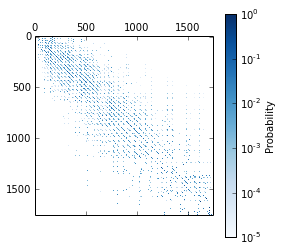

In [6]:
sc = plt.matshow(slice, cmap=cm.Blues,vmin=0.00001, vmax=1,norm=colors.LogNorm())
plt.colorbar(sc).set_label('Probability')
plt.show()

Symmetrize the adjacency matrix $A$:

$$ \frac{A + A^T}{2} $$

In [9]:
symmetric = (slice + slice.T)/2

In [15]:
g = nx.from_numpy_matrix(symmetric)
lspec = nx.laplacian_spectrum(g)
aspec = nx.adjacency_spectrum(g)

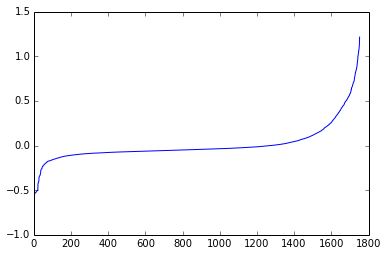

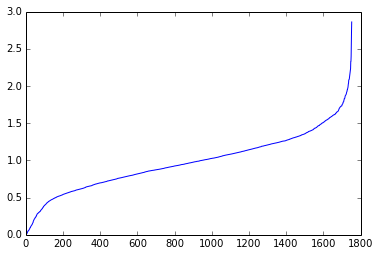

2.7322491554


In [17]:
plt.plot(sorted(aspec))
plt.show()
plt.plot(sorted(lspec))
plt.show()
print lspec[-2]

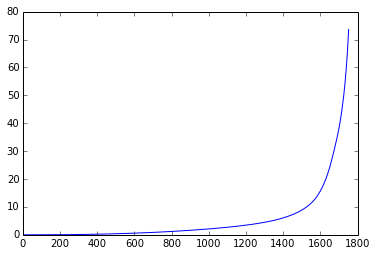

In [18]:
plt.plot(np.cumsum(sorted([a**2 for a in aspec])))
plt.show()

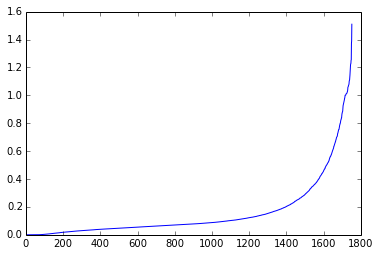

In [19]:
plt.plot(sorted(np.linalg.svd(slice, compute_uv=0)))

In [16]:
sparse = sps.coo_matrix(symmetric)

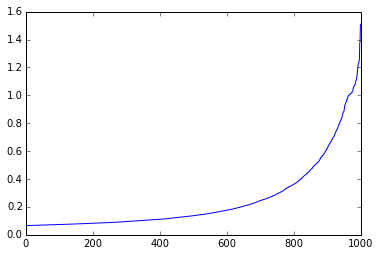

In [23]:
spec = sps.linalg.svds(slice, k=1000, return_singular_vectors=False)
plt.plot(spec)